### CRNPy example using Hydroinnova, Inc neutron detector rover readings

In [2]:
import pandas as pd
import numpy as np
from crnpy import crnpy

In [3]:
# Read the dataset
df = pd.read_csv("example_readings/Konza_KS_2108181329.KSU", skiprows=20, names=["RecordNum", "Date_Time(UTC)", "PTB110_mb", "P4_mb", "P1_mb", "T1_C", "RH1", "T_CS215", "RH_CS215", "Vbat", "N1Cts", "N2Cts", "N3Cts", "N4Cts", "N5Cts", "N6Cts", "N7Cts", "N8Cts", "N1ETsec", "N3ETsec", "N5ETsec", "N7ETsec", "N1T(C)", "N1RH", "N5T(C)", "N5RH", "GpsUTC", "LatDec", "LongDec", "Alt", "Qual", "NumSats", "HDOP", "Speed_kmh", "COG", "SpeedQuality", "strDate"])

# Define columns names
counts_colums = ['N1Cts', 'N2Cts', 'N3Cts','N4Cts', 'N5Cts', 'N6Cts', 'N7Cts', 'N8Cts']
cont_times_col = ['N1ETsec', 'N1ETsec', 'N3ETsec','N3ETsec', 'N5ETsec', 'N5ETsec', 'N7ETsec', 'N7ETsec']

# Parse timestamps and set as index
df['timestamp'] = pd.to_datetime(df['Date_Time(UTC)'])
df.set_index(df['timestamp'], inplace=True)

# Normalize counts to counts/h
df[counts_colums] = \
    crnpy.normalize_counts(df[counts_colums], \
                           count_time=60, count_times=df[cont_times_col])

df['total_counts'] = crnpy.compute_total_raw_counts(df[counts_colums])


<AxesSubplot: xlabel='timestamp'>

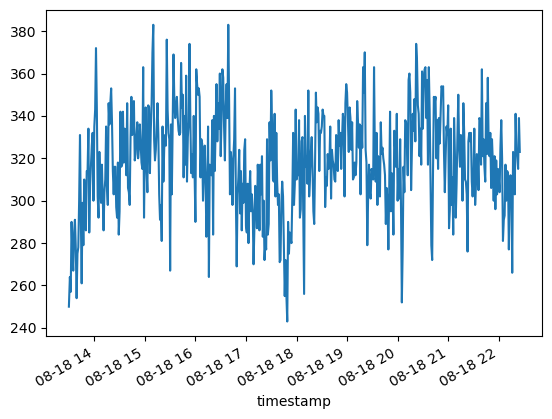

In [4]:
df['total_counts'].plot()

In [5]:
df['total_counts']=crnpy.drop_outlier(df['total_counts'], min_counts=240, max_counts=380)

#Find stations with cutoff rigidity similar to estimated by lat,lon
crnpy.find_neutron_detectors(crnpy.cutoff_rigidity(39.1, -96.6), timestamps=df['timestamp'])

#Download data for one of the similar stations and add to df
incoming_neutrons = crnpy.get_incoming_neutron_flux(df['timestamp'], station="NEWK")

Discarded counts below 240: 0
Discarded counts above 380: 2
Discarded 5 outliers using modified Z-score.

Select a station with an altitude similar to that of your location. For more information go to: 'https://www.nmdb.eu/nest/help.php#helpstations

Your cutoff rigidity is 2.87 GV
     STID     NAME     R  Altitude_m  Period available
13   DRBS  Dourbes  3.18         225              True
40   NEWK   Newark  2.40          50              True
28  KIEL2   KielRT  2.36          54              True
Check time resolution, or try the interpolate_incoming_neutron_flux() method.


In [6]:
# Interpolate incomming flux hourly to measured timestamps.
df['incoming_flux']=crnpy.interpolate_incoming_flux(incoming_neutrons, timestamps=df['timestamp'])

In [7]:
# Fill NaN values in atmospheric data
df[['PTB110_mb', 'RH_CS215', 'T_CS215']] = crnpy.fill_missing_atm(df[['PTB110_mb', 'RH_CS215', 'T_CS215']])

# Correct count by atmospheric variables and incoming flux
df['corrected']=crnpy.atm_correction(counts=df['total_counts'], pressure=df['PTB110_mb'], humidity=df['RH_CS215'], temp=df['T_CS215'],
                                     Pref=df['PTB110_mb'].mean(), Aref=0, L=130, incoming_neutrons=df['incoming_flux']).dropna() 

df['counts']=crnpy.fill_counts(df['corrected'])
df['counts'] = crnpy.smooth_counts(df['counts'].dropna(), window=17, order=3)


Using median count time as expected count time: 60.0


C:\Users\jperaza\Anaconda3\envs\GIS\lib\site-packages\crnpy\crnpy.py:358: UserWarning: Reference incoming neutron flux not provided. Using first value of incoming neutron flux.
  warnings.warn('Reference incoming neutron flux not provided. Using first value of incoming neutron flux.')
C:\Users\jperaza\Anaconda3\envs\GIS\lib\site-packages\crnpy\crnpy.py:107: UserWarning: No count time columns provided. Using timestamp index to compute count time.
  warnings.warn("No count time columns provided. Using timestamp index to compute count time.")


In [8]:
df['VWC']=crnpy.counts_to_vwc(df['counts'], N0=550, bulk_density=1.3, Wlat=0.03, Wsoc=0.01)
df['VWC']=crnpy.fill_missing_vwc(df['VWC'])

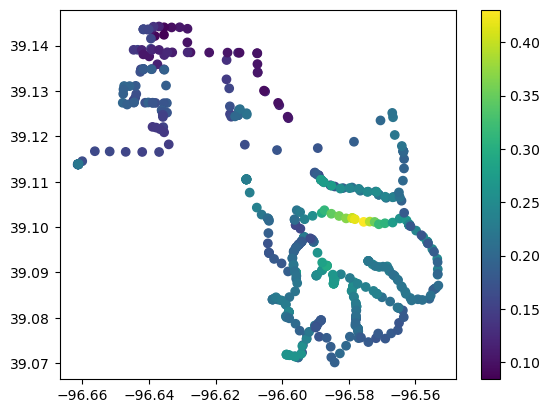

In [10]:
import matplotlib.pyplot as plt

#Plot the observation on space
plt.scatter(-df['LongDec'], df['LatDec'], c=df['VWC'])
plt.colorbar()